In [59]:
# Cargar librerías
import pandas as pd  # Manejo de dataframes
import numpy as np  # Manejo de arrays

In [60]:
# Cargar datos de sqlite3
import sqlite3

conn = sqlite3.connect("data/df.db")  # Conectar a la base de datos (ruta)
df = pd.read_sql_query("SELECT * FROM df", conn)  # Leer la tabla df
conn.close()  # Cerrar la conexión
df.head()  # Mostrar las primeras 5 filas

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,mean_time,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,target,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,7.373651,3.0,4.0,2.0,3,3,0,None,No,No
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,7.718969,3.0,2.0,4.0,2,4,1,2016-10-15 00:00:00,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,7.013240,2.0,2.0,1.0,3,3,0,None,No,No
3,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,7.193678,4.0,4.0,3.0,2,3,0,None,No,No
4,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,8.006175,4.0,1.0,3.0,3,3,0,None,No,No


In [61]:
# Quitar retirementDate, retirementType y retirementReason porque puede generar un sesgo en el modelo
df.drop(["retirementDate", "retirementType", "resignationReason"], axis=1, inplace=True)


# Reemplazar los valores nan de EnvironmentSatisfaction, JobSatisfaction y WorkLifeBalance por la moda de ese empleado en su departamento
df["EnvironmentSatisfaction"] = df.groupby("Department")[
    "EnvironmentSatisfaction"
].transform(lambda x: x.fillna(x.mode()[0]))

df["JobSatisfaction"] = df.groupby("Department")["JobSatisfaction"].transform(
    lambda x: x.fillna(x.mode()[0])
)
df["WorkLifeBalance"] = df.groupby("Department")["WorkLifeBalance"].transform(
    lambda x: x.fillna(x.mode()[0])
)

In [62]:
from sklearn.model_selection import train_test_split

# Separación de caracteristicas y target (X , y)
y = df.target
X = df.drop(["target"], axis=1)

# Separación en conjuntos de entrenamiento y validación con 70% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_test.shape)

Tamaño del conjunto de entrenamiento: (3067, 25)
Tamaño del conjunto de validación: (1315, 25)


In [63]:
# Seleccionar variables numéricas int64 y float64
numeric_columns = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_columns = list(X.select_dtypes("object").columns)

# Estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Modelos

In [79]:
# Lista de modelos que tienen más interpretabilidad para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier  # Ensamble con boosting
from xgboost import XGBClassifier  # Ensamble con boosting

models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
}

# Entrenar los modelos
for model in models:
    models[model].fit(X_train, y_train)

# Evaluar los modelos con validación cruzada con 5 folds y F1 como métrica en train y test con su desviación estándar
from sklearn.model_selection import cross_validate

for model in models:
    cv_results = cross_validate(
        models[model],
        X_train,
        y_train,
        cv=5,
        scoring="f1",
        return_train_score=True,
    )
    print(
        f"{model}\nF1 train: {cv_results['train_score'].mean():.3f} +/- {cv_results['train_score'].std():.3f}\nF1 test: {cv_results['test_score'].mean():.3f} +/- {cv_results['test_score'].std():.3f}\n"
    )

LogisticRegression
F1 train: 0.384 +/- 0.007
F1 test: 0.358 +/- 0.037

DecisionTreeClassifier
F1 train: 1.000 +/- 0.000
F1 test: 0.854 +/- 0.021

RandomForestClassifier
F1 train: 1.000 +/- 0.000
F1 test: 0.900 +/- 0.016

GradientBoostingClassifier
F1 train: 0.768 +/- 0.012
F1 test: 0.620 +/- 0.017

XGBClassifier
F1 train: 1.000 +/- 0.000
F1 test: 0.904 +/- 0.018



In [112]:
# Optimizar hiperparámetros de XGBoost con GridSearchCV buscando el F1 similar en train y test
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a optimizar
param_grid = {
    "max_depth": [1, 2, 3],
    "min_child_weight": [1, 3, 5],
    "gamma": [1, 3, 5],
    # "learning_rate": [0.1, 0.2, 0.3],
    # "subsample": [0.1, 0.5, 1],
    # "colsample_bytree": [0.5, 0.6, 0.7],
}

# Definir el modelo
xgb = XGBClassifier(
    eval_metric="f1",  # Función de pérdida a optimizar
    early_stopping_rounds=10,  # Detener el entrenamiento si no mejora en 10 iteraciones
)

# Definir la búsqueda
grid_search = GridSearchCV(
    xgb,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1,
)

# Entrenar la búsqueda
grid_search.fit(
    X_train, y_train, verbose=True, eval_set=[(X_train, y_train), (X_test, y_test)]
)

# Mejores hiperparámetros y su F1 en train y test
print(
    f"Mejores hiperparámetros: {grid_search.best_params_}\nF1 train: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.3f}\nF1 test: {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]:.3f}"
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[0]	validation_0-logloss:0.55453	validation_1-logloss:0.55529
[1]	validation_0-logloss:0.47663	validation_1-logloss:0.47713
[2]	validation_0-logloss:0.42878	validation_1-logloss:0.43059
[3]	validation_0-logloss:0.39808	validation_1-logloss:0.39918
[4]	validation_0-logloss:0.37549	validation_1-logloss:0.37741
[5]	validation_0-logloss:0.35665	validation_1-logloss:0.36161
[6]	validation_0-logloss:0.34423	validation_1-logloss:0.35078
[7]	validation_0-logloss:0.33262	validation_1-logloss:0.34287
[8]	validation_0-logloss:0.32274	validation_1-logloss:0.33641
[9]	validation_0-logloss:0.31529	validation_1-logloss:0.33117
[10]	validation_0-logloss:0.30700	validation_1-logloss:0.32203
[11]	validation_0-logloss:0.30166	validation_1-logloss:0.31858
[12]	validation_0-logloss:0.29491	validation_1-logloss:0.31390
[13]	validation_0-logloss:0.28892	validation_1-logloss:0.30791
[14]	validation_0-logloss:0.28353	validation_1-logloss:0.30405
[15

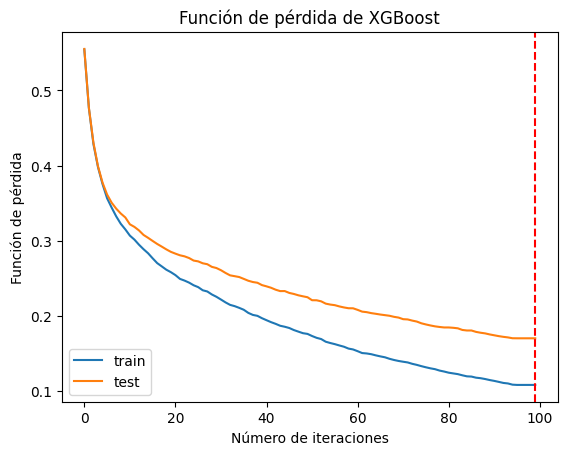

In [123]:
# Grafica de perdida para evaluar sobreajuste
import matplotlib.pyplot as plt

plt.plot(
    grid_search.best_estimator_.evals_result_["validation_0"]["logloss"], label="train"
)
plt.plot(
    grid_search.best_estimator_.evals_result_["validation_1"]["logloss"], label="test"
)
# Graficar donde la funcion de perdida de test y perdida de train se cruzan
plt.axvline(
    x=np.argmin(grid_search.best_estimator_.evals_result_["validation_1"]["logloss"]),
    color="red",
    linestyle="--",
)
plt.xlabel("Número de iteraciones")
plt.ylabel("Función de pérdida")
plt.title("Función de pérdida de XGBoost")

plt.legend()
plt.show()

# Mejor modelo

In [ ]:
# Seleccionar el mejor modelo con el mejor F1 en test
best_model = models["XGBClassifier"]

# Predecir con el mejor modelo
y_pred = best_model.predict(X_test)

# Evaluar F1 en train y test
from sklearn.metrics import f1_score

print(
    f"F1 train: {f1_score(y_train, best_model.predict(X_train)):.3f}\nF1 test: {f1_score(y_test, y_pred):.3f}"
)

F1 train: 1.000
F1 test: 0.949


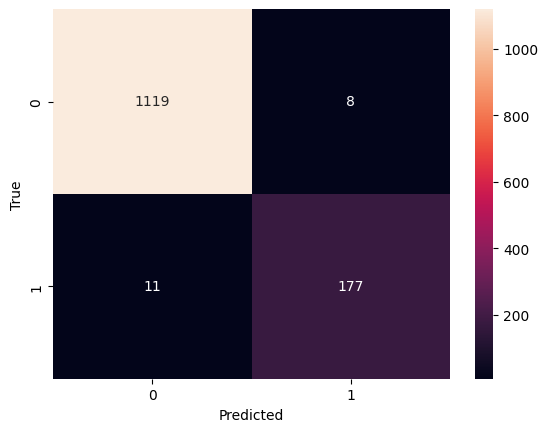

,Feature,Importance
25,EducationField_Human Resources,0.055734
44,MaritalStatus_Single,0.044175
33,JobRole_Healthcare Representative,0.041868
42,MaritalStatus_Divorced,0.038313
8,TotalWorkingYears,0.035236
27,EducationField_Marketing,0.035037
19,BusinessTravel_Non-Travel,0.032541
41,JobRole_Sales Representative,0.032278
11,YearsSinceLastPromotion,0.030759
20,BusinessTravel_Travel_Frequently,0.030531


In [43]:
# Seleccionar el modelo con el mejor F1
best_model = XGBClassifier()  # Se selecciona el modelo con mejor F1
best_model.fit(
    X_train, y_train
)  # Se entrena el modelo con todo el conjunto de entrenamiento

# F1 del modelo en train y test
print(
    f"F1 train: {f1_score(y_train, best_model.predict(X_train)):.3f}\nF1 test: {f1_score(y_test, best_model.predict(X_test)):.3f}"
)


# Matriz de confusión
from sklearn.metrics import confusion_matrix  # Matriz de confusión
import seaborn as sns  # Gráficos estadísticos
import matplotlib.pyplot as plt  # Gráficos

y_pred = best_model.predict(X_test)  # Predicciones
cm = confusion_matrix(y_test, y_pred)  # Matriz de confusión
sns.heatmap(cm, annot=True, fmt="d")  # Gráfico de la matriz de confusión
plt.xlabel("Predicted")  # Etiqueta eje x
plt.ylabel("True")  # Etiqueta eje y
plt.show()  # Mostrar gráfico

# Tabla de características más importantes
importances = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_,
    }
)
importances.sort_values(by="Importance", ascending=False).head(
    25
)  # Ordenar por importancia y mostrar las 25 más importantes

# Gráfico de SHAP

El gráfico de SHAP nos sirve para dar interpretabilidad a los modelos de manera global, notemos como cambia el orden de las variables respecto a la tabla anterior

EXPLICACIÓN GRÁFICOS SHAP
* En el eje y izquierdo vemos la variables más importantes de acuerdo a su importancia absoluta
* El eje X nos muestra el valor SHAP. Hacia la derecha, tenemos un valor positivo, lo que indica que aumenta el valor de la predicción final. Hacia la izquierda, el valor es negativo, por lo que tendría el efecto contrario.
* La dimensión del color nos muestra el valor de la variable normalizado. En color rojo vemos valores altos de la variable, y en azul bajos.

In [44]:
# Importar librerías para calcular los SHAP values
import shap

explainer = shap.TreeExplainer(best_model)  # Crear el objeto explainer
shap_values = explainer.shap_values(X_train)  # Calcular los SHAP values

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


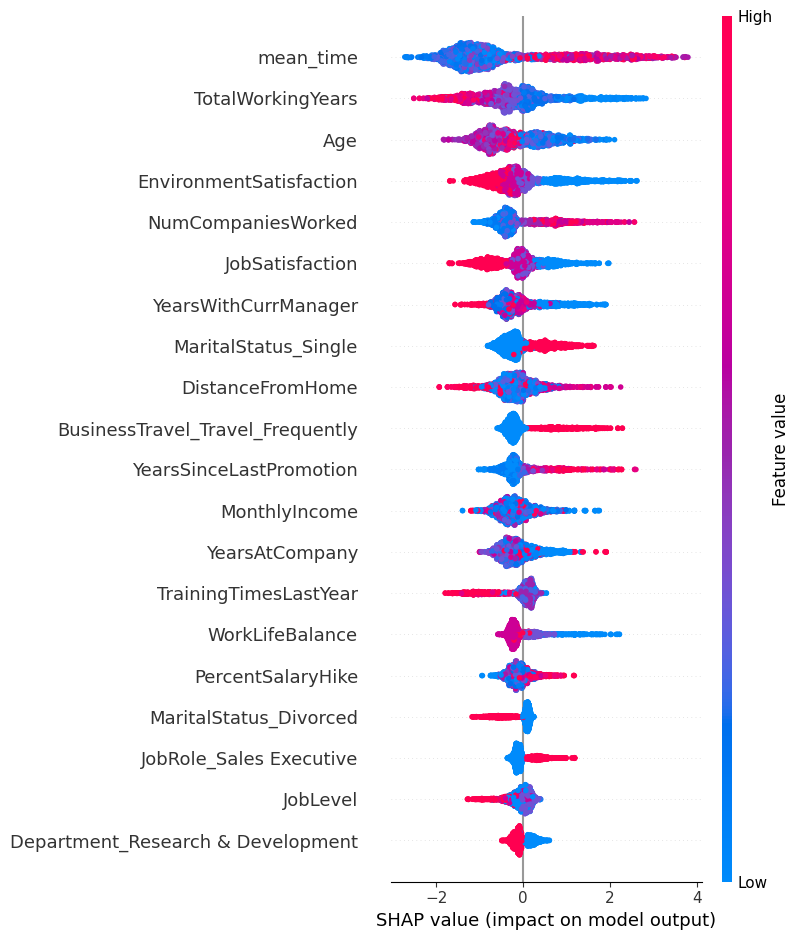

In [45]:
# Gráfico de barras de SHAP values para cada variable
shap.summary_plot(shap_values, X_train)

RESUMEN:
* Entre menos años haya trabajado hasta ahora ese empleado es más propenso a renunciar
* La edad se tomaría de la misma manera a valores bajos de la edad es más propenso a que renuncie
* En el numero de compañias pasa el caso contrario, si ha trabajado en muchas compañias, el empleado tiende a renunciar
* Entre menos años tengan con el actual director son más propensos a renunciar
* Los solteros tienden a renunciar
* En la parte de los ingresos mensuales es muy variable
* Entre más años hayan pasado desde el último asenso tienden a renunciar

Fuente de gráficos de SHAP
https://www.modeldifferently.com/2023/02/que-es-shap-explicabilidad-de-modelos-shap/